In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product
from datetime import datetime
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import ScalarFormatter, NullFormatter

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

In [2]:
data_directory = '../../16FlYMaze/PAvEL_learning_4y/data/'

# Define File Exceptions
file_exceptions = []

# Define Non-functional Arenas (arenas that had leaks or were otherwise unusable)
arena_exceptions = [4,5,6,7,8,9,10,11,12,13,14,15]

In [3]:
files = list(filter(lambda v: np.all([i not in v for i in file_exceptions]) and os.path.isdir(data_directory+v),os.listdir(data_directory)))
arenas = list(filter(lambda v: np.all([i != v for i in arena_exceptions]),range(16)))

In [4]:
all_data_unfiltered = []

for i,folder in tqdm(product(arenas,files),total=len(arenas)*len(files)):
    try:
        with open(data_directory+f"{folder}/processed_data/fly_{i}.ydata", "r") as f:
            data = json.load(f)
            for d in data.keys():
                data[d] = np.array(data[d])
        with open(data_directory+f"{folder}/fly_{i}.yexperiment", "r") as f:
            experiment = json.load(f)
            data["fly_experiment"] = experiment["fly_experiment"]
            data["arena"] = i
            data["folder"] = folder
        with open(data_directory+f"{folder}/config.yarena", "r") as f:
            config = json.load(f)
            data["odor_1"] = config["odor_1"]
            data["odor_2"] = config["odor_2"]
        all_data_unfiltered.append(data)
    except Exception as e:
        print(f"Failed to load data for fly {i} in folder {folder}. Error: {e}")

  0%|          | 0/100 [00:00<?, ?it/s]

Failed to load data for fly 0 in folder callibration_5_250_4_2022-08-23_00-05. Error: [Errno 2] No such file or directory: '../../16FlYMaze/PAvEL_learning_4y/data/callibration_5_250_4_2022-08-23_00-05/processed_data/fly_0.ydata'
Failed to load data for fly 1 in folder callibration_5_250_10_2022-08-24_00-53. Error: [Errno 2] No such file or directory: '../../16FlYMaze/PAvEL_learning_4y/data/callibration_5_250_10_2022-08-24_00-53/processed_data/fly_1.ydata'
Failed to load data for fly 1 in folder callibration_5_250_24_2022-08-26_19-30. Error: [Errno 2] No such file or directory: '../../16FlYMaze/PAvEL_learning_4y/data/callibration_5_250_24_2022-08-26_19-30/processed_data/fly_1.ydata'
Failed to load data for fly 1 in folder callibration_5_250_5_2022-08-23_12-17. Error: [Errno 2] No such file or directory: '../../16FlYMaze/PAvEL_learning_4y/data/callibration_5_250_5_2022-08-23_12-17/processed_data/fly_1.ydata'


In [5]:
# make a copy of the data
all_data = all_data_unfiltered.copy()
# filter data to only include flies that have completed at least 160 trials
all_data = list(filter(lambda v: v["trial_count"] >= 100,all_data))

# print all experiments
exps, invs, counts = np.unique([d["fly_experiment"] for d in all_data],return_counts=True,return_inverse=True)
for i in range(len(exps)):
    print(f"{exps[i]}: {counts[i]} flies")
exp_to_idx = {exps[i]:i for i in range(len(exps))}
idx_to_exp = {i:exps[i] for i in range(len(exps))}

# assign names to experiments
exp_names = [
    'EL->PA (R=0.125)',
    'PA->EL (R=0.125)',
    'EL->PA (R=0.25)',
    'PA->EL (R=0.25)',
    'EL->PA (R=0.50)',
    'PA->EL (R=0.50)',
    'EL->PA (R=1.00)',
    'PA->EL (R=1.00)',
    ]


switch45_0-125_5_250-500.csv: 10 flies
switch45_0-125_5_250-500_reciprocal.csv: 11 flies
switch45_0-250_5_250-500.csv: 10 flies
switch45_0-250_5_250-500_reciprocal.csv: 10 flies
switch45_0-500_5_250-500.csv: 10 flies
switch45_0-500_5_250-500_reciprocal.csv: 9 flies
switch45_1-000_5_250-500.csv: 10 flies
switch45_1-000_5_250-500_reciprocal.csv: 10 flies


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


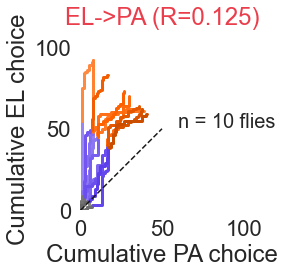

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


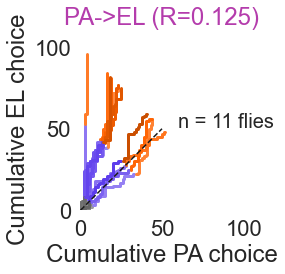

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


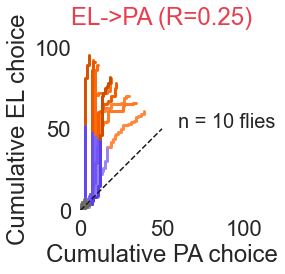

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


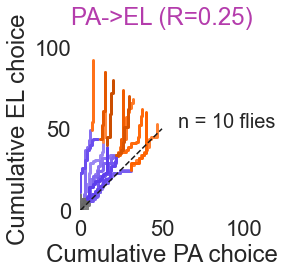

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


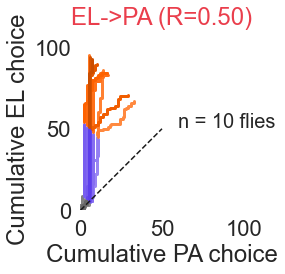

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


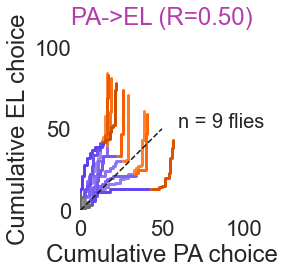

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


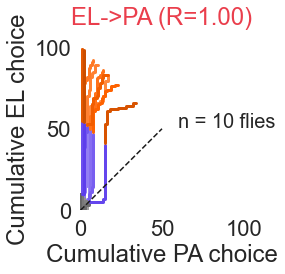

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


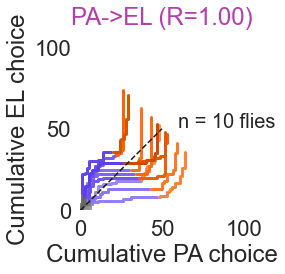

In [6]:
# plot all flies for each experiment
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]
    # randomize order of flies
    np.random.shuffle(data)

    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(3,3))
    for i in range(len(data)):
        odor1_choice = np.cumsum(1-(data[i]['chosen_odor']-1))
        odor2_choice = np.cumsum(data[i]['chosen_odor']-1)

        exp = data[i]["fly_experiment"]
        scaler = 1 + (i/len(data) - 0.5)*0.5
        cval=0.25
        ax.plot(odor1_choice[:10], odor2_choice[:10], '-', color = change_lightness((0.5,0.5,0.5,1),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[10:55], odor2_choice[10:55], '-', color = change_lightness(cmap(cval),scaler), alpha=1, linewidth=3)
        ax.plot(odor1_choice[55:100], odor2_choice[55:100], '-', color = change_lightness(cmap(1-cval),scaler), alpha=1, linewidth=3)
        
    # add a text box with the number of flies
    textstr = f"n = {len(data)} flies"
    ax.text(60, 60, textstr, fontsize=20, verticalalignment='top')
    
    plt.box(False)
    ax.plot([0,50],[0,50], 'k--')
    ax.set_xlabel("Cumulative PA choice")
    ax.set_ylabel("Cumulative EL choice")
    limits = np.max([ax.get_xlim(),ax.get_ylim()])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.set_title(exp_name, color = cmap(0.4) if 'PA->EL' in exp_name else cmap(0.6), y=1.1)
    ax.set_aspect('equal')
    alt_exp_name = exp_name.replace(' ','_').replace('->','_').replace('(','').replace(')','')
    plt.savefig(f"figures/Cumulative_Choice_{alt_exp_name}.pdf",bbox_inches='tight')
    
    plt.show()

In [7]:
# plot all flies for each fly

# define logit function
def logit(x):
    x = (x+1)/2
    x = np.clip(x,1/100,1-(1/100))
    return np.log(x/(1-x))

dfs = []
for exp_name,exp in zip(exp_names,exps):
    data = [d for d in all_data if d["fly_experiment"] == exp]

    folders = [d["folder"] for d in data]
    arenas = [d["arena"] for d in data]
    def get_CI(choices):
        choices = 2*(choices-1.5)
        return np.mean(choices)

    naive_CIs = np.array([get_CI(d['chosen_odor'][:10]) for d in data])
    trained_CIs = np.array([get_CI(d['chosen_odor'][10:55]) for d in data])
    reversal_CIs = np.array([get_CI(d['chosen_odor'][55:]) for d in data])
    if 'EL->PA' in exp_name:
        df = pd.DataFrame(
            {
            'Naive':naive_CIs,
            'Training':trained_CIs,
            'Reversal':reversal_CIs,
            'Experiment':'EL->PA',
            'Probability':exp_name.split('R=')[1][:-1],
            # 'Arena':arenas,
            # 'Folder':folders,
            'PA LI':logit(trained_CIs)-logit(reversal_CIs),
            'EL LI':logit(trained_CIs)-logit(naive_CIs)
            }
        )
    else:
        df = pd.DataFrame(
            {
            'Naive':naive_CIs,
            'Training':trained_CIs,
            'Reversal':reversal_CIs,
            'Experiment':'PA->EL',
            'Probability':exp_name.split('R=')[1][:-1],
            'PA LI':logit(naive_CIs)-logit(trained_CIs),
            'EL LI':logit(reversal_CIs)-logit(trained_CIs)
            }
        )
    dfs.append(df)

df = pd.concat(dfs) 
df = pd.melt(df, id_vars=['Experiment','Probability'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Naive Choice Index t-test: t=7.45, p=0.00


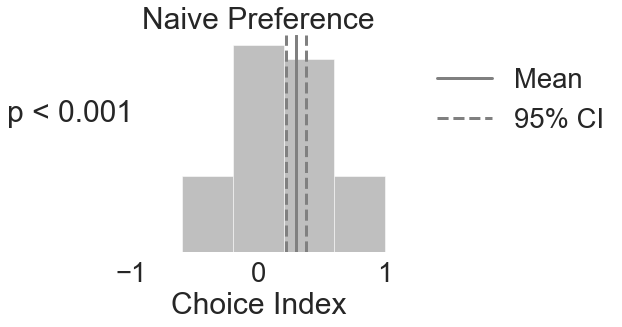

In [8]:
# plot a histogram of naive choice indices
sns.set(font_scale=2.5,style='white')
fig, ax = plt.subplots(figsize=(5,4))
plt.hist(df[df['Condition'] == 'Naive']['Choice Index'],bins=np.linspace(-1,1,6),color='gray',alpha=0.5)
# plot mean and 95% CI (bootstrap)
n_boot = 1000
boot_means = np.zeros(n_boot)
for i in range(n_boot):
    boot_means[i] = np.mean(np.random.choice(df[df['Condition'] == 'Naive']['Choice Index'],len(df[df['Condition'] == 'Naive']['Choice Index'])))
plt.axvline(np.mean(boot_means),color='gray',linewidth=3, label='Mean')
plt.axvline(np.percentile(boot_means,2.5),color='gray',linewidth=3,linestyle='--', label='95% CI')
plt.axvline(np.percentile(boot_means,97.5),color='gray',linewidth=3,linestyle='--')
# calculate one-sample t-test
t,p = stats.ttest_1samp(df[df['Condition'] == 'Naive']['Choice Index'],0)
print(f"Naive Choice Index t-test: t={t:.2f}, p={p:.2f}")
if p < 0.001:
    pstr = 'p < 0.001'
else:
    pstr = f'p = {p:.3f}'
plt.text(-0.4,0.6,pstr,transform=ax.transAxes)
plt.xlabel("Choice Index")
plt.xticks([-1,0,1])
plt.ylabel("")
plt.yticks([])
plt.title("Naive Preference")
plt.box(False)
plt.gca().spines['bottom'].set_visible(False)
plt.legend(frameon=False,bbox_to_anchor=(1.1, 0.9), loc='upper left', borderaxespad=0.)
plt.savefig("figures/PA_EL_Naive_Preference.pdf",bbox_inches='tight')
plt.show()


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PA->EL_Training vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:1.079e-02 Stat=1.000e+00
PA->EL_Naive vs. PA->EL_Training: Wilcoxon test (paired samples), P_val:2.441e-02 Stat=8.000e+00
EL->PA_Naive vs. EL->PA_Training: Wilcoxon test (paired samples), P_val:1.232e-01 Stat=9.500e+00
EL->PA_Training vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
PA->EL_Naive vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:6.910e-03 Stat=1.000e+00
EL->PA_Naive vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.900e+01


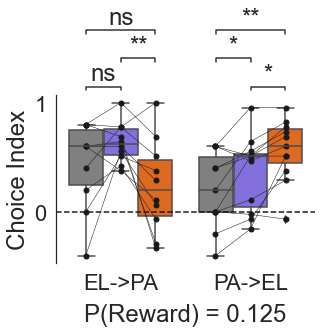

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PA->EL_Training vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
PA->EL_Naive vs. PA->EL_Training: Wilcoxon test (paired samples), P_val:9.528e-01 Stat=2.200e+01
EL->PA_Naive vs. EL->PA_Training: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
EL->PA_Training vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:4.383e-02 Stat=5.500e+00
PA->EL_Naive vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
EL->PA_Naive vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:2.077e-02 Stat=3.000e+00


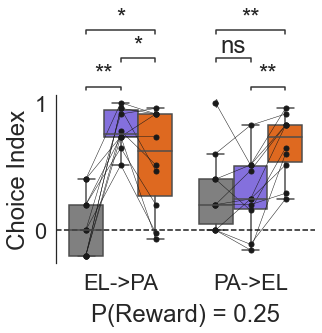

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PA->EL_Training vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=0.000e+00
PA->EL_Naive vs. PA->EL_Training: Wilcoxon test (paired samples), P_val:9.766e-02 Stat=7.500e+00
EL->PA_Naive vs. EL->PA_Training: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
EL->PA_Training vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=9.500e+00
PA->EL_Naive vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:3.906e-02 Stat=5.000e+00
EL->PA_Naive vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:6.445e-02 Stat=9.000e+00


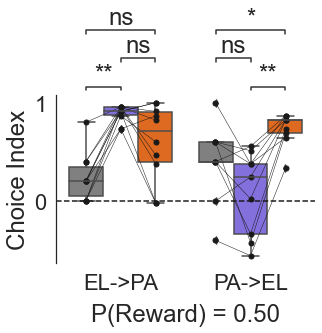

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calcu

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PA->EL_Training vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
PA->EL_Naive vs. PA->EL_Training: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
EL->PA_Naive vs. EL->PA_Training: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
EL->PA_Training vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:2.088e-02 Stat=3.000e+00
PA->EL_Naive vs. PA->EL_Reversal: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
EL->PA_Naive vs. EL->PA_Reversal: Wilcoxon test (paired samples), P_val:1.230e-01 Stat=7.000e+00


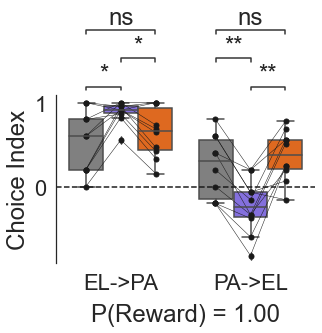

In [9]:
# make a paired boxplot of the data

df = pd.concat(dfs)
df = pd.melt(df, id_vars=['Experiment','Probability'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index')


for R in df['Probability'].unique():
    df = pd.concat(dfs)
    df = pd.melt(df, id_vars=['Experiment','Probability'], value_vars=['Naive','Training','Reversal'], var_name='Condition', value_name='Choice Index') 
    df = df[df['Probability'] == R]

    sns.set(font_scale=2,style='white')
    fig, ax = plt.subplots(figsize=(5,6))

    sns.boxplot(x='Experiment',y='Choice Index',hue='Condition',data=df,ax=ax,palette=[(0.5,0.5,0.5,1),cmap(0.25),cmap(0.75)])
    plt.legend([],[], frameon=False)
    ax.plot([-0.27,0,0.27],[df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='Naive')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='Training')]['Choice Index'].values,    
                        df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
    ax.plot([0.73,1,1.27],[df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='Naive')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='Training')]['Choice Index'].values,
                        df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='Reversal')]['Choice Index'].values],'-',color='k',marker='o',markersize=5,linewidth=0.5)
    
    ax.set_xlim([-0.5,1.5])
    ax.set_ylabel('Choice Index')
    ax.set_yticks([0,1])
    ax.set_xlabel(f'P(Reward) = {R}',labelpad=10)
    ax.set_xticklabels(['EL->PA','PA->EL'])

    # turn off all the spines except the left
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    # add significance
    pairs = [[('PA->EL','Naive'),('PA->EL','Training')],
                [('PA->EL','Naive'),('PA->EL','Reversal')],
                [('PA->EL','Training'),('PA->EL','Reversal')],
                [('EL->PA','Naive'),('EL->PA','Training')],
                [('EL->PA','Naive'),('EL->PA','Reversal')],
                [('EL->PA','Training'),('EL->PA','Reversal')]]

    annotator = Annotator(ax, pairs, data=df, x='Experiment', y='Choice Index', hue='Condition')
    annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # draw horizontal lines at 0
    ax.axhline(0, ls='--', color='k')

    plt.tight_layout()
    plt.savefig(f"figures/PA-EL_Choice_Index_{R}.pdf",bbox_inches='tight')
    plt.show()

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EL LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:7.337e-01 U_stat=5.500e+01
PA LI_EL->PA vs. PA LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:9.097e-01 U_stat=5.200e+01
PA LI_PA->EL vs. EL LI_EL->PA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.896e-01 U_stat=3.550e+01
PA LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.274e-01 U_stat=3.900e+01


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EL LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:3.725e-02 U_stat=7.100e+01
PA LI_EL->PA vs. PA LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.382e-01 U_stat=4.800e+01
PA LI_PA->EL vs. EL LI_EL->PA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.596e-02 U_stat=1.500e+01
PA LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:5.401e-01 U_stat=3.700e+01


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EL LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.507e-02 U_stat=7.700e+01
PA LI_EL->PA vs. PA LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.508e-01 U_stat=6.950e+01
PA LI_PA->EL vs. EL LI_EL->PA: Mann-Whitney-Wilcoxon test two-sided, P_val:1.309e-03 U_stat=7.000e+00
PA LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:4.727e-01 U_stat=4.000e+01


c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

EL LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:8.601e-01 U_stat=5.200e+01
PA LI_EL->PA vs. PA LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:2.765e-03 U_stat=9.800e+01
PA LI_PA->EL vs. EL LI_EL->PA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.654e-02 U_stat=2.300e+01
PA LI_EL->PA vs. EL LI_PA->EL: Mann-Whitney-Wilcoxon test two-sided, P_val:1.051e-01 U_stat=7.850e+01


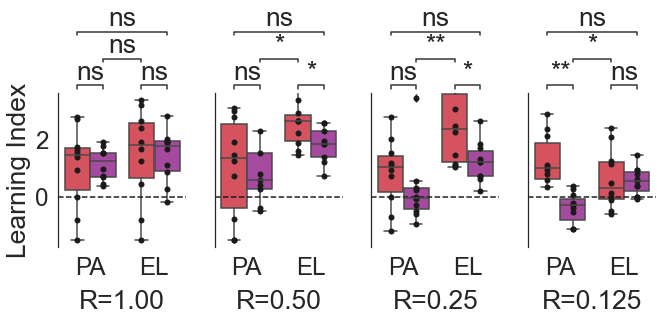

In [10]:
# make a paired boxplot of the data
sns.set(font_scale=2.2,style='white')
fig, axs = plt.subplots(1,4,figsize=(10,6),sharey=True,sharex=True)

df = pd.concat(dfs)

ps = df['Probability'].unique()
# reverse the order of the probabilities
ps = ps[::-1]

for i,R in enumerate(ps):
    ax = axs[i]
    df = pd.concat(dfs)
    df = pd.melt(df, id_vars=['Experiment','Probability'], value_vars=['PA LI','EL LI'], var_name='Condition', value_name='Learning Index')
    df = df[df['Probability'] == R]

    sns.boxplot(x='Condition',y='Learning Index',hue='Experiment',data=df,ax=ax,palette=[cmap(0.6),cmap(0.4)])
    ax.plot(-0.2*np.ones_like(df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='PA LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='PA LI')]['Learning Index'].values,'o',color='k',markersize=5)
    ax.plot(0.2*np.ones_like(df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='PA LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='PA LI')]['Learning Index'].values,'o',color='k',markersize=5)
    
    ax.plot(0.8*np.ones_like(df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='EL LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='EL->PA',df['Condition']=='EL LI')]['Learning Index'].values,'o',color='k',markersize=5)
    ax.plot(1.2*np.ones_like(df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='EL LI')]['Learning Index'].values),
                df[np.logical_and(df['Experiment']=='PA->EL',df['Condition']=='EL LI')]['Learning Index'].values,'o',color='k',markersize=5)

    # add legend at bottom
    ax.legend([],[], frameon=False)
    ax.set_xlim([-0.5,1.5])
    if i == 0:
        ax.set_ylabel('Learning Index')
    else:
        ax.set_ylabel('')
    ax.set_xlabel(f'R={R}',labelpad=10)
    ax.set_xticklabels(['PA','EL'])

    # turn off all the spines except the left
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    # add significance
    pairs = [[('PA LI','EL->PA'),('PA LI','PA->EL')],
                [('EL LI','EL->PA'),('EL LI','PA->EL')],
                [('PA LI','PA->EL'),('EL LI','EL->PA')],
                [('PA LI','EL->PA'),('EL LI','PA->EL')]]

    annotator = Annotator(ax, pairs, data=df, x='Condition', y='Learning Index', hue='Experiment')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # draw horizontal lines at 0
    ax.axhline(0, ls='--', color='k')

plt.tight_layout()
plt.savefig(f"figures/PA-EL_Learning_Index.pdf",bbox_inches='tight')
plt.show()


In [11]:
df = pd.concat(dfs)
df = pd.melt(df, id_vars=['Experiment','Probability'], value_vars=['PA LI','EL LI'], var_name='Odor', value_name='Learning_Index')
df.columns = ['Order','P_R','Odor','Learning_Index']

# run a ANOVA to test for differences in learning index between experiments, probabilities, and odors
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# define the model
model = anova_lm(ols('Learning_Index ~ C(Order) + C(P_R) + C(Odor) + C(Order):C(P_R) + C(Order):C(Odor) + C(P_R):C(Odor) + C(Order):C(P_R):C(Odor)', data=df).fit())

# save the results
model.to_csv('data/PA-EL_Learning_Index_ANOVA.csv')
model

,df,sum_sq,mean_sq,F,PR(>F)
C(Order),1.0,12.149058,12.149058,9.256622,0.002789
C(P_R),3.0,30.973852,10.324617,7.866542,0.000067
C(Odor),1.0,25.657988,25.657988,19.549358,0.000019
C(Order):C(P_R),3.0,5.816209,1.938736,1.477164,0.223271
C(Order):C(Odor),1.0,0.000113,0.000113,0.000086,0.992600
C(P_R):C(Odor),3.0,7.864809,2.621603,1.997454,0.117021
C(Order):C(P_R):C(Odor),3.0,7.125734,2.375245,1.809749,0.148031
Residual,144.0,188.995995,1.312472,NaN,NaN
